# Wordle Simulation Analysis

This notebook allows you to run Wordle simulations and generate various graphs for analysis. You can experiment with different strategies and parameters, and visualize the results to gain insights into performance.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../backend"))
print("sys.path:", sys.path)
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import inspect

from utils.word_list_loader import ANSWER_LIST, ANSWER_LIST_LENGTH
from utils.filter import get_feedback_pattern
from services.filter_strategy import filter_strategy
from services.entropy_strategy import strategy_entrypoint as entropy_strategy
from services.frequency_strategy import best_guess_frequency as frequency_strategy
from services.partition_strategy import best_guess_partition as partition_strategy
from services.minimax_strategy import best_guess_minimax as minimax_strategy
from classes.GameState import GameState
from services.entropy_strategy import ENTROPY_CACHE, ENTROPY_CACHE_LOCK

# Set up matplotlib and seaborn styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

sys.path: ['c:\\Users\\lewis\\Documents\\projects\\WordleSolver\\simulation', 'c:\\Users\\lewis\\anaconda3\\python38.zip', 'c:\\Users\\lewis\\anaconda3\\DLLs', 'c:\\Users\\lewis\\anaconda3\\lib', 'c:\\Users\\lewis\\anaconda3', '', 'C:\\Users\\lewis\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages\\win32', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages\\Pythonwin', 'c:\\Users\\lewis\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\lewis\\.ipython', 'c:\\Users\\lewis\\Documents\\projects\\WordleSolver\\backend']


In [2]:
STRATEGY_MAP = {
    'entropy': lambda *args, **kwargs: entropy_strategy(*args, **kwargs),
    'frequency': lambda answers, guesses=None: frequency_strategy(answers, guesses),
    'partition': lambda answers, guesses=None: partition_strategy(answers, guesses, get_feedback_pattern),
    'minimax': lambda answers, guesses=None: minimax_strategy(answers, guesses, get_feedback_pattern),
    'filter': lambda answers, guesses=None: filter_strategy(answers, guesses),
}

In [3]:
def simulate_single_word(answer: str, strategy: str, start_word: str, **kwargs) -> dict:
    game_state = GameState(answer, start_word)
    strategy_func = STRATEGY_MAP.get(strategy)
    return game_state.solve(lambda *a, **k: strategy_func(*a, **k), **kwargs)

In [ ]:
def simulate_wordle(strategy: str, hard_mode: bool, start_word: str, **kwargs) -> dict:
    # Clear the entropy cache once per simulation
    with ENTROPY_CACHE_LOCK:
        ENTROPY_CACHE.clear()
    start_word = str(start_word).lower()
    details = []
    guess_distribution = defaultdict(int)
    start_time = time.time()
    for idx, answer in enumerate(ANSWER_LIST):
        result = simulate_single_word(answer, strategy, start_word, **kwargs)
        print(f"Simulating {idx + 1}/{ANSWER_LIST_LENGTH}: {answer} - Result: {result['guesses']}")
        details.append(result)
        guess_distribution[result['guesses']] += 1
    end_time = time.time()
    total_guesses = sum(int(k) * v for k, v in guess_distribution.items())
    avg_guesses = total_guesses / (len(details) if details else 1)
    min_guesses = min(map(int, guess_distribution.keys())) if guess_distribution else 0
    max_guesses = max(map(int, guess_distribution.keys())) if guess_distribution else 0
    unsolved_words = [d['answer'] for d in details if not d['solved']]
    return {
        'summary': {
            'strategy': strategy,
            'startWord': start_word,
            'hardMode': hard_mode,
        },
        'stats': {
            'guesses': {
                'totalGuesses': total_guesses,
                'avgGuesses': avg_guesses,
                'maxGuesses': max_guesses,
                'minGuesses': min_guesses
            },
            'time': {
                'slowestTime': max(details, key=lambda x: x['timeTakenMs'])['timeTakenMs'] if details else 0,
                'fastestTime': min(details, key=lambda x: x['timeTakenMs'])['timeTakenMs'] if details else 0,
                'totalTime': int((end_time - start_time) * 1000),
                'avgTime': int((end_time - start_time) * 1000 / (len(details) if details else 1))
            },
            'words': {
                'totalWords': ANSWER_LIST_LENGTH,
                'solvedWords': len([d for d in details if d['solved']]),
                'unsolvedWords': unsolved_words,
            },
            'distribution': dict(guess_distribution)
        },
        'details': details
    }


In [13]:
sim_args = [
     {'strategy': 'entropy', 'hard_mode': False, 'start_word': 'salet', 
     'sort': True, 'parallel': False, 'use_cache': False, 
     'use_guesses': False, 'use_precomputed': False},
     {'strategy': 'entropy', 'hard_mode': False, 'start_word': 'salet', 
     'sort': True, 'parallel': True, 'use_cache': False,
     'use_guesses': False, 'use_precomputed': False},
]
sim_results = []
for sim in sim_args:
    results = simulate_wordle(
        strategy=sim['strategy'], 
        hard_mode=sim['hard_mode'], 
        start_word=sim['start_word'], 
        sort=sim['sort'], 
        parallel=sim['parallel'],
        use_cache=sim['use_cache'],
        use_guesses=sim['use_guesses'],
        use_precomputed=sim['use_precomputed']
    )
    sim_results.append(results)

Simulating 1/2315: aback - Result: 3
Simulating 2/2315: abase - Result: 4
Simulating 3/2315: abate - Result: 3
Simulating 4/2315: abbey - Result: 3
Simulating 5/2315: abbot - Result: 4
Simulating 6/2315: abhor - Result: 3
Simulating 7/2315: abide - Result: 3
Simulating 8/2315: abled - Result: 2
Simulating 9/2315: abode - Result: 4
Simulating 10/2315: abort - Result: 3
Simulating 11/2315: about - Result: 3
Simulating 12/2315: above - Result: 3
Simulating 13/2315: abuse - Result: 3
Simulating 14/2315: abyss - Result: 3
Simulating 15/2315: acorn - Result: 3
Simulating 16/2315: acrid - Result: 3
Simulating 17/2315: actor - Result: 3
Simulating 18/2315: acute - Result: 3
Simulating 19/2315: adage - Result: 3
Simulating 20/2315: adapt - Result: 3
Simulating 21/2315: adept - Result: 3
Simulating 22/2315: admin - Result: 3
Simulating 23/2315: admit - Result: 4
Simulating 24/2315: adobe - Result: 4
Simulating 25/2315: adopt - Result: 4
Simulating 26/2315: adore - Result: 3
Simulating 27/2315: a

In [15]:
for sim in sim_results:
    print("\n" + "="*40)
    print("Simulation Results")
    print(f"Strategy: {sim['summary']['strategy']}")
    print(f"Start Word: {sim['summary']['startWord']}")
    print(f"Hard Mode: {'Yes' if sim['summary']['hardMode'] else 'No'}")
    print(f"Total Words: {sim['stats']['words']['totalWords']}")
    print(f"Unsolved Words: {len(sim['stats']['words']['unsolvedWords'])}")
    print(f"Average Guesses: {sim['stats']['guesses']['avgGuesses']:.3f}")
    print(f"Max Guesses: {sim['stats']['guesses']['maxGuesses']}")
    print(f"Slowest Time: {sim['stats']['time']['slowestTime']}ms")
    print(f"Fastest Time: {sim['stats']['time']['fastestTime']}ms")
    print(f"Average Time: {sim['stats']['time']['avgTime']}ms")
    print(f"Total Time: {sim['stats']['time']['totalTime'] / 1000:.2f}s")
    print("\nGuess Distribution:")
    for guesses, count in sim['stats']['distribution'].items():
        print(f"{guesses} guesses: {count}")
    if sim['stats']['words']['unsolvedWords']:
        print("\nUnsolved Words:")
        print(", ".join(sim['stats']['words']['unsolvedWords']))



Simulation Results
Strategy: entropy
Start Word: salet
Hard Mode: No
Total Words: 2315
Unsolved Words: 8
Average Guesses: 3.541
Max Guesses: 8
Slowest Time: 262ms
Fastest Time: 6ms
Average Time: 31ms
Total Time: 74.07s

Guess Distribution:
3 guesses: 1013
4 guesses: 952
2 guesses: 148
5 guesses: 166
6 guesses: 28
7 guesses: 7
8 guesses: 1

Unsolved Words:
foyer, pound, tatty, vaunt, waste, watch, wight, wound

Simulation Results
Strategy: entropy
Start Word: salet
Hard Mode: No
Total Words: 2315
Unsolved Words: 11
Average Guesses: 3.541
Max Guesses: 8
Slowest Time: 310ms
Fastest Time: 7ms
Average Time: 50ms
Total Time: 117.48s

Guess Distribution:
3 guesses: 1021
4 guesses: 933
2 guesses: 153
5 guesses: 163
6 guesses: 34
7 guesses: 10
8 guesses: 1

Unsolved Words:
bound, foyer, gaunt, hound, paste, pound, taste, tatty, vaunt, waste, watch


## 1. Summary Table for All Simulations

This cell creates a summary table comparing key statistics for each simulation run.

,Strategy,Start Word,Hard Mode,Sort,Parallel,Use Cache,Use Guesses,Use Precomputed,Avg Guesses,Max Guesses,Min Guesses,Unsolved Words,Avg Time (ms),Total Time (s)
0,entropy,salet,False,True,False,False,False,False,3.541253,8,2,8,31,74.071
1,entropy,salet,False,True,True,False,False,False,3.541253,8,2,11,50,117.480


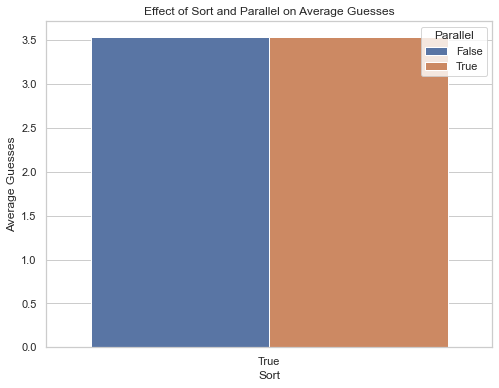

In [14]:
import pandas as pd

# Collect summary stats for each simulation
summary_data = []
for i, sim in enumerate(sim_results):
    summary = sim['summary']
    stats = sim['stats']
    sim_arg = sim_args[i]
    summary_data.append({
        'Strategy': summary['strategy'],
        'Start Word': summary['startWord'],
        'Hard Mode': summary['hardMode'],
        'Sort': sim_arg['sort'],
        'Parallel': sim_arg['parallel'],
        'Use Cache': sim_arg['use_cache'],
        'Use Guesses': sim_arg['use_guesses'],
        'Use Precomputed': sim_arg['use_precomputed'],
        'Avg Guesses': stats['guesses']['avgGuesses'],
        'Max Guesses': stats['guesses']['maxGuesses'],
        'Min Guesses': stats['guesses']['minGuesses'],
        'Unsolved Words': len(stats['words']['unsolvedWords']),
        'Avg Time (ms)': stats['time']['avgTime'],
        'Total Time (s)': stats['time']['totalTime'] / 1000
    })
summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Visualize effect of sort and parallel on average guesses
plt.figure(figsize=(8,6))
sns.barplot(data=summary_df, x='Sort', y='Avg Guesses', hue='Parallel')
plt.title('Effect of Sort and Parallel on Average Guesses')
plt.ylabel('Average Guesses')
plt.show()

## 2. Guess Distribution Comparison

This cell visualizes the guess distribution for each simulation as a grouped bar plot.

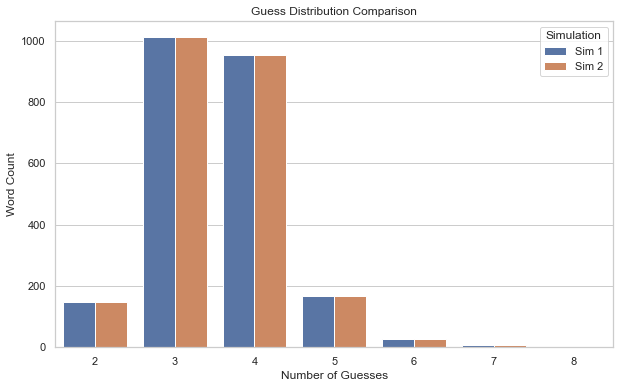

In [8]:
# Prepare guess distribution data
all_distributions = []
for idx, sim in enumerate(sim_results):
    dist = sim['stats']['distribution']
    for guesses, count in dist.items():
        all_distributions.append({
            'Simulation': f"Sim {idx+1}",
            'Guesses': int(guesses),
            'Count': count
        })
dist_df = pd.DataFrame(all_distributions)

plt.figure(figsize=(10,6))
sns.barplot(data=dist_df, x='Guesses', y='Count', hue='Simulation')
plt.title('Guess Distribution Comparison')
plt.xlabel('Number of Guesses')
plt.ylabel('Word Count')
plt.legend(title='Simulation')
plt.show()

## 3. Box Plot: Time per Word per Simulation

This cell shows the distribution of time taken per word for each simulation using a box plot.

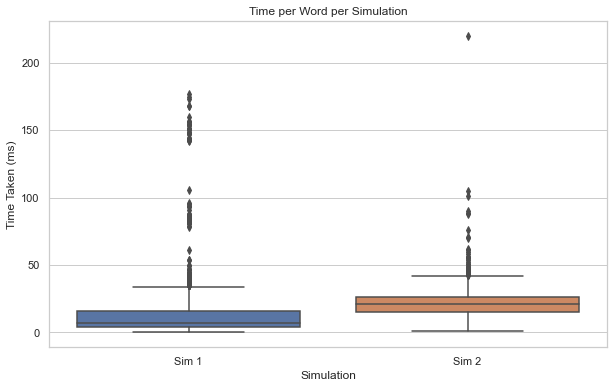

In [9]:
# Prepare time per word data
all_times = []
for idx, sim in enumerate(sim_results):
    for detail in sim['details']:
        all_times.append({
            'Simulation': f"Sim {idx+1}",
            'Time (ms)': detail['timeTakenMs']
        })
time_df = pd.DataFrame(all_times)

plt.figure(figsize=(10,6))
sns.boxplot(data=time_df, x='Simulation', y='Time (ms)')
plt.title('Time per Word per Simulation')
plt.ylabel('Time Taken (ms)')
plt.show()

## 4. Venn Diagram: Overlap of Unsolved Words

This cell visualizes the overlap of unsolved words between up to three simulations using a Venn diagram.

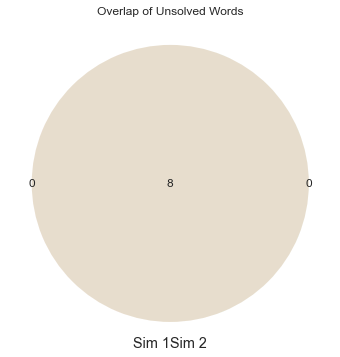

In [10]:
from matplotlib_venn import venn2, venn3

# Get sets of unsolved words for up to 3 simulations
unsolved_sets = [set(sim['stats']['words']['unsolvedWords']) for sim in sim_results[:3]]
labels = [f"Sim {i+1}" for i in range(len(unsolved_sets))]

plt.figure(figsize=(8,6))
if len(unsolved_sets) == 2:
    venn2(unsolved_sets, set_labels=labels)
elif len(unsolved_sets) == 3:
    venn3(unsolved_sets, set_labels=labels)
else:
    print("Venn diagram supports only 2 or 3 sets.")
plt.title('Overlap of Unsolved Words')
plt.show()

## 5. Heatmap: Guesses per Word Across Simulations

This cell creates a heatmap showing the number of guesses for each word across all simulations, highlighting difficult or inconsistent words.

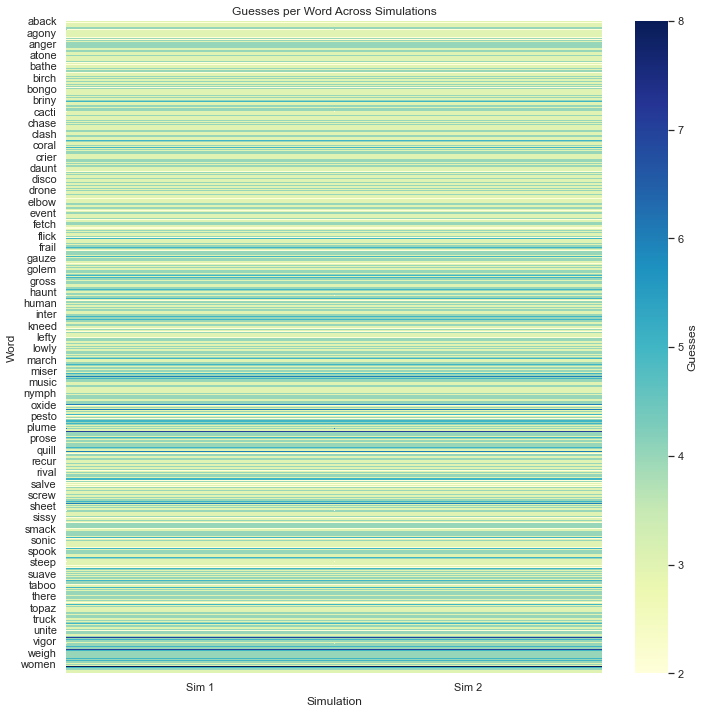

In [11]:
# Build a DataFrame: rows=words, columns=Sim 1, Sim 2, ...
words = [detail['answer'] for detail in sim_results[0]['details']]
guess_data = {'Word': words}
for idx, sim in enumerate(sim_results):
    guesses = [detail['guesses'] for detail in sim['details']]
    guess_data[f"Sim {idx+1}"] = guesses
guess_df = pd.DataFrame(guess_data).set_index('Word')

plt.figure(figsize=(12, min(12, 0.3*len(words))))
sns.heatmap(guess_df, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Guesses'})
plt.title('Guesses per Word Across Simulations')
plt.xlabel('Simulation')
plt.ylabel('Word')
plt.show()